Source: http://bugtriage.mybluemix.net/


# Import librairies

In [1]:
# Required dependencies
# 1. NLTK
# 2. Gensim for word2vec
# 3. Keras with tensorflow/theano backend


import numpy as np
np.random.seed(1337)
import json, re, nltk, string
from nltk.corpus import wordnet
from gensim.models import Word2Vec
from keras.preprocessing import sequence
from keras.models import Model
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, merge
from keras.optimizers import RMSprop
from keras.utils import np_utils
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics.pairwise import cosine_similarity

Using TensorFlow backend.


In [2]:
from keras.layers import BatchNormalization, Concatenate
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Load data

In [3]:
# open_bugs_json = '/home/anussank/icse/data/chrome/deep_data.json'
# closed_bugs_json = '/home/anussank/icse/data/chrome/classifier_data_10.json'
open_bugs_json = 'data/deep_data.json' #'/home/data/chrome/deep_data.json'
closed_bugs_json = 'data/train_test_json/classifier_data_0.json' #'/home/data/chrome/classifier_data_0.json'

# Initialize

In [4]:
#========================================================================================
# Initializing Hyper parameter
#========================================================================================
#1. Word2vec parameters
min_word_frequency_word2vec = 5
embed_size_word2vec = 200
context_window_word2vec = 5

#2. Classifier hyperparameters
numCV = 10
max_sentence_len = 50
min_sentence_length = 15
rankK = 10
batch_size = 32

# Preprocess

In [5]:
#========================================================================================
# Preprocess the open bugs, extract the vocabulary and learn the word2vec representation
#========================================================================================
with open(open_bugs_json) as data_file:
    data = json.load(data_file, strict=False)

all_data = []
for item in data:
    #1. Remove \r 
    current_title = item['issue_title'].replace('\r', ' ')
    current_desc = item['description'].replace('\r', ' ')    
    #2. Remove URLs
    current_desc = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', current_desc)    
    #3. Remove Stack Trace
    start_loc = current_desc.find("Stack trace:")
    current_desc = current_desc[:start_loc]    
    #4. Remove hex code
    current_desc = re.sub(r'(\w+)0x\w+', '', current_desc)
    current_title= re.sub(r'(\w+)0x\w+', '', current_title)    
    #5. Change to lower case
    current_desc = current_desc.lower()
    current_title = current_title.lower()    
    #6. Tokenize
    current_desc_tokens = nltk.word_tokenize(current_desc)
    current_title_tokens = nltk.word_tokenize(current_title)
    #7. Strip trailing punctuation marks    
    current_desc_filter = [word.strip(string.punctuation) for word in current_desc_tokens]
    current_title_filter = [word.strip(string.punctuation) for word in current_title_tokens]      
    #8. Join the lists
    current_data = current_title_filter + current_desc_filter
    #current_data = filter(None, current_data)  # by tan
    all_data.append(current_data)  

# Learn the word2vec model and extract vocabulary
wordvec_model = Word2Vec(all_data, min_count=min_word_frequency_word2vec, size=embed_size_word2vec, window=context_window_word2vec)
# vocabulary = wordvec_model.vocab
vocabulary = wordvec_model.wv.vocab
vocab_size = len(vocabulary)
print('Vocab size: ', vocab_size)

Vocab size:  71576


In [21]:
# EDA
with open(open_bugs_json) as data_file:
    data = json.load(data_file, strict=False)

In [23]:
all_data = []
count = 0
for item in data:
    if count == 2: 
        break
    
    #1. Remove \r 
    current_title = item['issue_title'].replace('\r', ' ')
    current_desc = item['description'].replace('\r', ' ')  
    print('title: ', current_title)
    print('description: ', current_desc)
    
    count += 1

title:  Testing if chromium id works
description:  
what steps will reproduce the problem
1
2
3
 
what is the expected output what do you see instead
 
 
please use labels and text to provide additional information
 

title:  This is a test
description:  
product version       0214927 
urls if applicable  httpwwwgooglecom 
other browsers tested
add ok or fail after other browsers where you have tested this issue
     safari 3 fail 
    firefox 3 fail 
         ie 7 fail 
 
what steps will reproduce the problem
1 eat 
2 sleep 
 
what is the expected result
3 wake up 
 
what happens instead
3 sleep continues unabated 
 
please provide any additional information below attach a screenshot if  
possible 
 



In [6]:
print(len(all_data))  # 163695 lines
print()
print(all_data[0])

163695

['testing', 'if', 'chromium', 'id', 'works', 'what', 'steps', 'will', 'reproduce', 'the', 'problem', '1', '2', '3', 'what', 'is', 'the', 'expected', 'output', 'what', 'do', 'you', 'see', 'instead', 'please', 'use', 'labels', 'and', 'text', 'to', 'provide', 'additional', 'information']


In [7]:
#========================================================================================
# Preprocess the closed bugs, using the extracted the vocabulary
#========================================================================================
with open(closed_bugs_json) as data_file:
    data = json.load(data_file, strict=False)

all_data2 = []
all_owner = []    
for item in data:
    #1. Remove \r 
    current_title = item['issue_title'].replace('\r', ' ')
    current_desc = item['description'].replace('\r', ' ')
    #2. Remove URLs
    current_desc = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', current_desc)
    #3. Remove Stack Trace
    start_loc = current_desc.find("Stack trace:")
    current_desc = current_desc[:start_loc]
    #4. Remove hex code
    current_desc = re.sub(r'(\w+)0x\w+', '', current_desc)
    current_title= re.sub(r'(\w+)0x\w+', '', current_title)
    #5. Change to lower case
    current_desc = current_desc.lower()
    current_title = current_title.lower()
    #6. Tokenize
    current_desc_tokens = nltk.word_tokenize(current_desc)
    current_title_tokens = nltk.word_tokenize(current_title)
    #7. Strip punctuation marks
    current_desc_filter = [word.strip(string.punctuation) for word in current_desc_tokens]
    current_title_filter = [word.strip(string.punctuation) for word in current_title_tokens]       
    #8. Join the lists
    current_data = current_title_filter + current_desc_filter
    #current_data = filter(None, current_data) # by Tan
    all_data2.append(current_data)
    all_owner.append(item['owner'])

In [9]:
print(len(all_data2))  # 118643 lines
print()
print(all_data2[0])

118643

['scrolling', 'with', 'some', 'scroll', 'mice', '', 'touchpad', '', 'etc', '', '', 'scrolls', 'down', 'but', 'not', 'up', 'product', 'version', '', '', 'see', 'about', '', 'version', '', 'urls', '', 'if', 'applicable', '', '0.2.149.27', 'other', 'browsers', 'tested', '', 'firefox', '', 'ie', 'add', 'ok', 'or', 'fail', 'after', 'other', 'browsers', 'where', 'you', 'have', 'tested', 'this', 'issue', '', 'safari', '3', '', 'firefox', '3', '', 'ok', 'ie', '7', '', 'ok', 'what', 'steps', 'will', 'reproduce', 'the', 'problem', '', '1', 'open', 'any', 'webpage', 'on', 'compaq', '6715s', 'running', 'vista', '', '2', 'try', 'scrolling', 'with', 'the', 'touchpad', '3', 'scrolling', 'down', 'will', 'work', '', 'but', 'up', 'will', 'not', '', 'what', 'is', 'the', 'expected', 'result', '', 'the', 'page', 'to', 'scroll', 'up', '', 'what', 'happens', 'instead', '', 'the', 'page', 'does', "n't", 'move', '', 'please', 'provide', 'any', 'additional', 'information', 'below', '', 'attach', 'a', 's

In [24]:
with open(closed_bugs_json) as data_file:
    data = json.load(data_file, strict=False)

# Split cross validation

## Cach 1: Cross validation 10 runs

In [ ]:
#========================================================================================
# Split cross validation sets and perform deep learning + softmax based classification
#========================================================================================
totalLength = len(all_data)
#splitLength = totalLength / (numCV + 1)

splitLength = int(totalLength / (numCV + 1))  # by Tan

for i in range(1, numCV+1):
    # Split cross validation set
    print(i)
    train_data = all_data[:i*splitLength-1]
    test_data = all_data[i*splitLength:(i+1)*splitLength-1]
    train_owner = all_owner[:i*splitLength-1]
    test_owner = all_owner[i*splitLength:(i+1)*splitLength-1]
    
    # Remove words outside the vocabulary
    updated_train_data = []    
    updated_train_data_length = []    
    updated_train_owner = []
    final_test_data = []
    final_test_owner = []
    for j, item in enumerate(train_data):
        current_train_filter = [word for word in item if word in vocabulary]
        if len(current_train_filter)>=min_sentence_length:  
            updated_train_data.append(current_train_filter)
            updated_train_owner.append(train_owner[j])  
      
    for j, item in enumerate(test_data):
        current_test_filter = [word for word in item if word in vocabulary]  
        if len(current_test_filter)>=min_sentence_length:
            final_test_data.append(current_test_filter)     
            final_test_owner.append(test_owner[j])    
    
    # Remove data from test set that is not there in train set
    train_owner_unique = set(updated_train_owner)
    test_owner_unique = set(final_test_owner)
    unwanted_owner = list(test_owner_unique - train_owner_unique)
    updated_test_data = []
    updated_test_owner = []
    updated_test_data_length = []
    for j in range(len(final_test_owner)):
    	if final_test_owner[j] not in unwanted_owner:
    		updated_test_data.append(final_test_data[j])
    		updated_test_owner.append(final_test_owner[j])

    unique_train_label = list(set(updated_train_owner))
    classes = np.array(unique_train_label)
    
    # Create train and test data for deep learning + softmax
    X_train = np.empty(shape=[len(updated_train_data), max_sentence_len, embed_size_word2vec], dtype='float32')
    Y_train = np.empty(shape=[len(updated_train_owner),1], dtype='int32')
    # 1 - start of sentence, # 2 - end of sentence, # 0 - zero padding. Hence, word indices start with 3 
    for j, curr_row in enumerate(updated_train_data):
        sequence_cnt = 0         
        for item in curr_row:
            if item in vocabulary:
                X_train[j, sequence_cnt, :] = wordvec_model[item] 
                sequence_cnt = sequence_cnt + 1                
                if sequence_cnt == max_sentence_len-1:
                    break                
        for k in range(sequence_cnt, max_sentence_len):
            X_train[j, k, :] = np.zeros((1,embed_size_word2vec))        
        Y_train[j,0] = unique_train_label.index(updated_train_owner[j])
    
    X_test = np.empty(shape=[len(updated_test_data), max_sentence_len, embed_size_word2vec], dtype='float32')
    Y_test = np.empty(shape=[len(updated_test_owner),1], dtype='int32')
    # 1 - start of sentence, # 2 - end of sentence, # 0 - zero padding. Hence, word indices start with 3 
    for j, curr_row in enumerate(updated_test_data):
        sequence_cnt = 0          
        for item in curr_row:
            if item in vocabulary:
                X_test[j, sequence_cnt, :] = wordvec_model[item] 
                sequence_cnt = sequence_cnt + 1                
                if sequence_cnt == max_sentence_len-1:
                    break                
        for k in range(sequence_cnt, max_sentence_len):
            X_test[j, k, :] = np.zeros((1,embed_size_word2vec))        
        Y_test[j,0] = unique_train_label.index(updated_test_owner[j])
        
    y_train = np_utils.to_categorical(Y_train, len(unique_train_label))
    y_test = np_utils.to_categorical(Y_test, len(unique_train_label))
    
    # Construct the deep learning model
    sequence = Input(shape=(max_sentence_len, embed_size_word2vec), dtype='float32')
    forwards_1 = LSTM(1024)(sequence)
    after_dp_forward_4 = Dropout(0.20)(forwards_1) 
    backwards_1 = LSTM(1024, go_backwards=True)(sequence)
    after_dp_backward_4 = Dropout(0.20)(backwards_1)         
    
    #merged = merge([after_dp_forward_4, after_dp_backward_4], mode='concat', concat_axis=-1)
    merged = Concatenate(axis=-1)([after_dp_forward_5, after_dp_backward_5]) # by Tan

    after_dp = Dropout(0.5)(merged)
    output = Dense(len(unique_train_label), activation='softmax')(after_dp)                
    model = Model(input=sequence, output=output)            
    rms = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy', optimizer=rms, metrics=['accuracy'])    
    hist = model.fit(X_train, y_train,
              batch_size=batch_size,
              nb_epoch=200)              
    
    predict = model.predict(X_test)        
    accuracy = []
    sortedIndices = []
    pred_classes = []
    for ll in predict:
   	    sortedIndices.append(sorted(range(len(ll)), key=lambda ii: ll[ii], reverse=True))
    for k in range(1, rankK+1):
      	id = 0
      	trueNum = 0
      	for sortedInd in sortedIndices:            
            pred_classes.append(classes[sortedInd[:k]])
            if y_test[id] in classes[sortedInd[:k]]:
                  trueNum += 1
            id += 1
      	accuracy.append((float(trueNum) / len(predict)) * 100)
    print('Test accuracy:', accuracy)       
    
    train_result = hist.history        
    print(train_result)
#     del model

## CACH 2: only 1 run

In [27]:
#========================================================================================
# Split cross validation sets and perform deep learning + softmax based classification
#========================================================================================

all_data = all_data2

totalLength = len(all_data)
#splitLength = totalLength / (numCV + 1)

splitLength = int(totalLength / (numCV + 1))  # by Tan

i = 1 

#for i in range(1, numCV+1):
# Split cross validation set
# print(i)
train_data = all_data[:i*splitLength-1]
test_data = all_data[i*splitLength:(i+1)*splitLength-1]
train_owner = all_owner[:i*splitLength-1]
test_owner = all_owner[i*splitLength:(i+1)*splitLength-1]


In [83]:
len(train_data), len(test_data), len(train_owner),len(test_owner)

(101321, 11042, 106777, 11865)

In [30]:
train_data = all_data2[:106778]
test_data = all_data2[106779:]
train_owner = all_owner[:106778]
test_owner = all_owner[106779:]

In [31]:
# #========================================================================================
# # Split cross validation sets and perform deep learning + softmax based classification
# #========================================================================================

# all_data = all_data2

# totalLength = len(all_data)
# #splitLength = totalLength / (numCV + 1)

# splitLength = int(totalLength / (numCV + 1))  # by Tan

# i = 1 

# #for i in range(1, numCV+1):
# # Split cross validation set
# # print(i)
# train_data = all_data[:i*splitLength-1]
# test_data = all_data[i*splitLength:(i+1)*splitLength-1]
# train_owner = all_owner[:i*splitLength-1]
# test_owner = all_owner[i*splitLength:(i+1)*splitLength-1]

# Remove words outside the vocabulary
updated_train_data = []    
updated_train_data_length = []    
updated_train_owner = []
final_test_data = []
final_test_owner = []

for j, item in enumerate(train_data):
    current_train_filter = [word for word in item if word in vocabulary]
    if len(current_train_filter)>=min_sentence_length:  
        updated_train_data.append(current_train_filter)
        updated_train_owner.append(train_owner[j])  

for j, item in enumerate(test_data):
    current_test_filter = [word for word in item if word in vocabulary]  
    if len(current_test_filter)>=min_sentence_length:
        final_test_data.append(current_test_filter)     
        final_test_owner.append(test_owner[j])    

# Remove data from test set that is not there in train set
train_owner_unique = set(updated_train_owner)
test_owner_unique = set(final_test_owner)
unwanted_owner = list(test_owner_unique - train_owner_unique)
updated_test_data = []
updated_test_owner = []
updated_test_data_length = []
for j in range(len(final_test_owner)):
    if final_test_owner[j] not in unwanted_owner:
        updated_test_data.append(final_test_data[j])
        updated_test_owner.append(final_test_owner[j])

unique_train_label = list(set(updated_train_owner))
classes = np.array(unique_train_label)

In [32]:
len(classes)  # 1067   avant
# 2488 , vendredi  18/12/2020 by Tan

2488

In [ ]:
# Create train and test data for deep learning + softmax
X_train = np.empty(shape=[len(updated_train_data), max_sentence_len, embed_size_word2vec], dtype='float32')
Y_train = np.empty(shape=[len(updated_train_owner),1], dtype='int32')
# 1 - start of sentence, # 2 - end of sentence, # 0 - zero padding. Hence, word indices start with 3 
for j, curr_row in enumerate(updated_train_data):
    sequence_cnt = 0         
    for item in curr_row:
        if item in vocabulary:
            X_train[j, sequence_cnt, :] = wordvec_model[item] 
            sequence_cnt = sequence_cnt + 1                
            if sequence_cnt == max_sentence_len-1:
                break                
    for k in range(sequence_cnt, max_sentence_len):
        X_train[j, k, :] = np.zeros((1,embed_size_word2vec))        
    Y_train[j,0] = unique_train_label.index(updated_train_owner[j])

X_test = np.empty(shape=[len(updated_test_data), max_sentence_len, embed_size_word2vec], dtype='float32')
Y_test = np.empty(shape=[len(updated_test_owner),1], dtype='int32')
# 1 - start of sentence, # 2 - end of sentence, # 0 - zero padding. Hence, word indices start with 3 
for j, curr_row in enumerate(updated_test_data):
    sequence_cnt = 0          
    for item in curr_row:
        if item in vocabulary:
            X_test[j, sequence_cnt, :] = wordvec_model[item] 
            sequence_cnt = sequence_cnt + 1                
            if sequence_cnt == max_sentence_len-1:
                break                
    for k in range(sequence_cnt, max_sentence_len):
        X_test[j, k, :] = np.zeros((1,embed_size_word2vec))        
    Y_test[j,0] = unique_train_label.index(updated_test_owner[j])

y_train = np_utils.to_categorical(Y_train, len(unique_train_label))
y_test = np_utils.to_categorical(Y_test, len(unique_train_label))

In [84]:
X_train.shape, y_train.shape, X_test.shape,  y_test.shape
# avant: 09/12/2020
# ((10381, 50, 200), (10381, 1067), (9886, 50, 200), (9886, 1067))

# après: vendredi 18/12/2020
# ((202644, 50, 200), (202644, 2488), (22082, 50, 200), (22082, 2488))

((101321, 50, 200), (101321, 2488), (11042, 50, 200), (11042, 2488))

In [32]:
X_train[0], y_train[0], X_test[0], y_test[0]

(array([[ 0.22469096,  0.2576209 ,  0.6956248 , ..., -1.7366828 ,
          1.6346624 ,  0.5874551 ],
        [-0.04907837,  0.11883479, -1.1162405 , ..., -0.09731878,
         -0.29285604,  1.5259653 ],
        [-2.7858768 ,  0.1168505 ,  1.0697929 , ...,  0.65944767,
         -0.38239878, -0.9349493 ],
        ...,
        [ 1.4598596 , -1.0121193 ,  0.23396486, ...,  2.1366057 ,
         -1.3014317 , -2.4536915 ],
        [-4.265397  , -0.41680485,  2.9812722 , ..., -0.666072  ,
          0.6138904 ,  1.2771595 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([[-1.2561258 ,  1.4994767 ,  1.730885  , ...,  0.33873758,
         -1.7706761 ,  0.3553048 ],
        [-2.5517073 ,  0.6060939 , -0.1045763 , ...,  1.2640077 ,
         -2.2921116 , -0.14901248],
        [-0.29732105, -0.63225764, -1.2456008 , ...,  0.8875281 ,
          0.32988724, -0.1749952 ]

In [86]:
# Construct the deep learning model
sequence = Input(shape=(max_sentence_len, embed_size_word2vec), dtype='float32')
forwards_1 = LSTM(1024)(sequence)
after_dp_forward_4 = Dropout(0.20)(forwards_1) 
backwards_1 = LSTM(1024, go_backwards=True)(sequence)
after_dp_backward_4 = Dropout(0.20)(backwards_1)         

# merged = merge([after_dp_forward_4, after_dp_backward_4], mode='concat', concat_axis=-1)
merged = Concatenate(axis=-1)([after_dp_forward_4, after_dp_backward_4]) # by Tan

after_dp = Dropout(0.5)(merged)
output = Dense(len(unique_train_label), activation='softmax')(after_dp)                
model = Model(input=sequence, output=output)            
rms = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08)
model.compile(loss='categorical_crossentropy', optimizer=rms, metrics=['accuracy'])    

model.summary() # architecture

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 200)      0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 1024)         5017600     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 1024)         5017600     input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)  

C:\Users\letan\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  del sys.path[0]


In [ ]:
# training
nb_epoch = 20
# hist = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=200)              
# hist = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch)  # by Tan

# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = model.fit(X_train, y_train, epochs=nb_epoch, validation_split=0.1, shuffle=True)

Instructions for updating:
Use tf.cast instead.


C:\Users\letan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Train on 91188 samples, validate on 10133 samples
Epoch 1/20
91188/91188 [==============================] - 502s 6ms/step - loss: 6.5854 - acc: 0.0491 - val_loss: 6.6996 - val_acc: 0.0570
Epoch 2/20
91188/91188 [==============================] - 438s 5ms/step - loss: 6.3097 - acc: 0.0711 - val_loss: 6.6882 - val_acc: 0.0641
Epoch 3/20
91188/91188 [==============================] - 437s 5ms/step - loss: 6.2817 - acc: 0.0778 - val_loss: 6.9481 - val_acc: 0.0661
Epoch 4/20
91188/91188 [==============================] - 4364s 48ms/step - loss: 6.3857 - acc: 0.0826 - val_loss: 7.2218 - val_acc: 0.0651
Epoch 5/20
91188/91188 [==============================] - 438s 5ms/step - loss: 6.4794 - acc: 0.0852 - val_loss: 7.4363 - val_acc: 0.0644
Epoch 6/20
91188/91188 [==============================] - 437s 5ms/step - loss: 6.5700 - acc: 0.0885 - val_loss: 7.5762 - val_acc: 0.0615
Epoch 7/20
91188/91188 [==============================] - 438s 5ms/step - loss: 6.6321 - acc: 0.0897 - val_loss: 7.6441 

In [85]:
# prediction from the trained model
predict = model.predict(X_test)        

accuracy = []
sortedIndices = []
pred_classes = []

for ll in predict:
    sortedIndices.append(sorted(range(len(ll)), key=lambda ii: ll[ii], reverse=True))
    
for k in range(1, rankK+1):
    id = 0
    trueNum = 0
    for sortedInd in sortedIndices:            
        pred_classes.append(classes[sortedInd[:k]])
        if y_test[id] in classes[sortedInd[:k]]:
              trueNum += 1
        id += 1
    accuracy.append((float(trueNum) / len(predict)) * 100)
    
print('Test accuracy:', accuracy)       

train_result = hist.history        
print(train_result)
#     del model

NameError: name 'model' is not defined

In [33]:
import matplotlib.pyplot as plt
import seaborn as sn

C:\Users\letan\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
C:\Users\letan\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


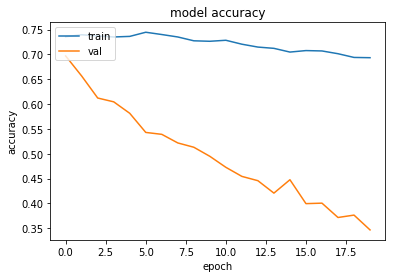

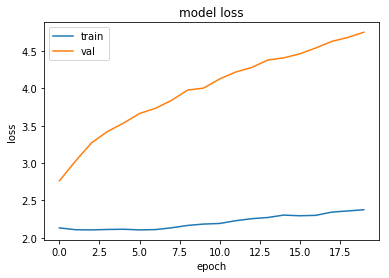

In [43]:
print(train_result.keys())
#  "Accuracy"
plt.plot(train_result['acc'])
plt.plot(train_result['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# "Loss"
plt.plot(train_result['loss'])
plt.plot(train_result['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Split - Baseline classifiers

## Cach 1: CV 10 runs

In [ ]:
#========================================================================================
# Split cross validation sets and perform baseline classifiers
#========================================================================================    
    
totalLength = len(all_data)
splitLength = totalLength / (numCV + 1)

for i in range(1, numCV+1):
    # Split cross validation set
    print(i)
    train_data = all_data[:i*splitLength-1]
    test_data = all_data[i*splitLength:(i+1)*splitLength-1]
    train_owner = all_owner[:i*splitLength-1]
    test_owner = all_owner[i*splitLength:(i+1)*splitLength-1]
    
    # Remove words outside the vocabulary
    updated_train_data = []    
    updated_train_data_length = []    
    updated_train_owner = []
    final_test_data = []
    final_test_owner = []
    for j, item in enumerate(train_data):
    	current_train_filter = [word for word in item if word in vocabulary]
    	if len(current_train_filter)>=min_sentence_length:  
    	  updated_train_data.append(current_train_filter)
    	  updated_train_owner.append(train_owner[j])  
    	  
    for j, item in enumerate(test_data):
    	current_test_filter = [word for word in item if word in vocabulary]  
    	if len(current_test_filter)>=min_sentence_length:
    	  final_test_data.append(current_test_filter)    	  
    	  final_test_owner.append(test_owner[j])    	  
    
    # Remove data from test set that is not there in train set
    train_owner_unique = set(updated_train_owner)
    test_owner_unique = set(final_test_owner)
    unwanted_owner = list(test_owner_unique - train_owner_unique)
    updated_test_data = []
    updated_test_owner = []
    updated_test_data_length = []
    for j in range(len(final_test_owner)):
    	if final_test_owner[j] not in unwanted_owner:
    		updated_test_data.append(final_test_data[j])
    		updated_test_owner.append(final_test_owner[j])  
    
    train_data = []
    for item in updated_train_data:
    	  train_data.append(' '.join(item))
         
    test_data = []
    for item in updated_test_data:
    	  test_data.append(' '.join(item))
    
    vocab_data = []
    for item in vocabulary:
    	  vocab_data.append(item)
    
    # Extract tf based bag of words representation
    tfidf_transformer = TfidfTransformer(use_idf=False)
    count_vect = CountVectorizer(min_df=1, vocabulary= vocab_data,dtype=np.int32)
    
    train_counts = count_vect.fit_transform(train_data)       
    train_feats = tfidf_transformer.fit_transform(train_counts)
    print(train_feats.shape)
    
    test_counts = count_vect.transform(test_data)
    test_feats = tfidf_transformer.transform(test_counts)
    print(test_feats.shape)
    print("=======================")
    
    # perform classifification
    for classifier in range(1,5):
        #classifier = 3 # 1 - Niave Bayes, 2 - Softmax, 3 - cosine distance, 4 - SVM
        print(classifier )
        if classifier == 1:            
            classifierModel = MultinomialNB(alpha=0.01)        
            classifierModel = OneVsRestClassifier(classifierModel).fit(train_feats, updated_train_owner)
            predict = classifierModel.predict_proba(test_feats)  
            classes = classifierModel.classes_  
            
            accuracy = []
            sortedIndices = []
            pred_classes = []
            for ll in predict:
                sortedIndices.append(sorted(range(len(ll)), key=lambda ii: ll[ii], reverse=True))
            for k in range(1, rankK+1):
                id = 0
                trueNum = 0
                for sortedInd in sortedIndices:            
                    if y_test[id] in classes[sortedInd[:k]]:
                        trueNum += 1
                        pred_classes.append(classes[sortedInd[:k]])
                    id += 1
                accuracy.append((float(trueNum) / len(predict)) * 100)
            print(accuracy)
        elif classifier == 2:            
            classifierModel = LogisticRegression(solver='lbfgs', penalty='l2', tol=0.01)
            classifierModel = OneVsRestClassifier(classifierModel).fit(train_feats, updated_train_owner)
            predict = classifierModel.predict(test_feats)
            classes = classifierModel.classes_ 
            
            accuracy = []
            sortedIndices = []
            pred_classes = []
            for ll in predict:
                sortedIndices.append(sorted(range(len(ll)), key=lambda ii: ll[ii], reverse=True))
            for k in range(1, rankK+1):
                id = 0
                trueNum = 0
                for sortedInd in sortedIndices:            
                    if y_test[id] in classes[sortedInd[:k]]:
                        trueNum += 1
                        pred_classes.append(classes[sortedInd[:k]])
                    id += 1
                accuracy.append((float(trueNum) / len(predict)) * 100)
            print(accuracy)                                  
        elif classifier == 3:            
            predict = cosine_similarity(test_feats, train_feats)
            classes = np.array(updated_train_owner)
            classifierModel = []
            
            accuracy = []
            sortedIndices = []
            pred_classes = []
            for ll in predict:
                sortedIndices.append(sorted(range(len(ll)), key=lambda ii: ll[ii], reverse=True))
            for k in range(1, rankK+1):
                id = 0
                trueNum = 0
                for sortedInd in sortedIndices:            
                    if y_test[id] in classes[sortedInd[:k]]:
                        trueNum += 1
                        pred_classes.append(classes[sortedInd[:k]])
                    id += 1
                accuracy.append((float(trueNum) / len(predict)) * 100)
            print(accuracy)                       
        elif classifier == 4:            
            classifierModel = svm.SVC(probability=True, verbose=False, decision_function_shape='ovr', random_state=42)
            classifierModel.fit(train_feats, updated_train_owner)
            predict = classifierModel.predict(test_feats)
            classes = classifierModel.classes_ 
        
            accuracy = []
            sortedIndices = []
            pred_classes = []
            for ll in predict:
                sortedIndices.append(sorted(range(len(ll)), key=lambda ii: ll[ii], reverse=True))
            for k in range(1, rankK+1):
                id = 0
                trueNum = 0
                for sortedInd in sortedIndices:            
                    if y_test[id] in classes[sortedInd[:k]]:
                        trueNum += 1
                        pred_classes.append(classes[sortedInd[:k]])
                    id += 1
                accuracy.append((float(trueNum) / len(predict)) * 100)
            print(accuracy)


## Cach 2: 1 run

In [37]:
#========================================================================================
# Split cross validation sets and perform baseline classifiers
#========================================================================================    
    
totalLength = len(all_data2) # 118643
splitLength = int(totalLength / (numCV + 1))  # 10785

#for i in range(1, numCV+1):
i = 1
# Split cross validation set
# print(i)
# train_data = all_data2[:i*splitLength-1]
# test_data = all_data2[i*splitLength:(i+1)*splitLength-1]
# train_owner = all_owner[:i*splitLength-1]
# test_owner = all_owner[i*splitLength:(i+1)*splitLength-1]

train_data = all_data2[:106778]
test_data = all_data2[106779:]
train_owner = all_owner[:106778]
test_owner = all_owner[106779:]

# Remove words outside the vocabulary
updated_train_data = []    
updated_train_data_length = []    
updated_train_owner = []
final_test_data = []
final_test_owner = []

In [38]:
splitLength

10785

In [39]:
len(train_data), len(test_data), len(train_owner),len(test_owner)

(106778, 11864, 106778, 11864)

In [40]:
len(all_data2), len(all_owner), len(all_data)
# (118643, 118643, 163695)

(118643, 118643, 118643)

In [41]:
#========================================================================================
# Split cross validation sets and perform baseline classifiers
#========================================================================================    
    
totalLength = len(all_data2)
splitLength = int(totalLength / (numCV + 1))

#for i in range(1, numCV+1):
i = 1
# Split cross validation set
# print(i)
train_data = all_data2[:i*splitLength-1]
test_data = all_data2[i*splitLength:(i+1)*splitLength-1]
train_owner = all_owner[:i*splitLength-1]
test_owner = all_owner[i*splitLength:(i+1)*splitLength-1]

# Remove words outside the vocabulary
updated_train_data = []    
updated_train_data_length = []    
updated_train_owner = []
final_test_data = []
final_test_owner = []

for j, item in enumerate(train_data):
    current_train_filter = [word for word in item if word in vocabulary]
    if len(current_train_filter)>=min_sentence_length:  
      updated_train_data.append(current_train_filter)
      updated_train_owner.append(train_owner[j])  

for j, item in enumerate(test_data):
    current_test_filter = [word for word in item if word in vocabulary]  
    if len(current_test_filter)>=min_sentence_length:
      final_test_data.append(current_test_filter)    	  
      final_test_owner.append(test_owner[j])    	  

# Remove data from test set that is not there in train set
train_owner_unique = set(updated_train_owner)
test_owner_unique = set(final_test_owner)
unwanted_owner = list(test_owner_unique - train_owner_unique)
updated_test_data = []
updated_test_owner = []
updated_test_data_length = []
for j in range(len(final_test_owner)):
    if final_test_owner[j] not in unwanted_owner:
        updated_test_data.append(final_test_data[j])
        updated_test_owner.append(final_test_owner[j])  

train_data = []
for item in updated_train_data:
      train_data.append(' '.join(item))

test_data = []
for item in updated_test_data:
      test_data.append(' '.join(item))

vocab_data = []
for item in vocabulary:
      vocab_data.append(item)

# Extract tf based bag of words representation
tfidf_transformer = TfidfTransformer(use_idf=False)
count_vect = CountVectorizer(min_df=1, vocabulary= vocab_data,dtype=np.int32)

train_counts = count_vect.fit_transform(train_data)       
train_feats = tfidf_transformer.fit_transform(train_counts)
print(train_feats.shape)

test_counts = count_vect.transform(test_data)
test_feats = tfidf_transformer.transform(test_counts)
print(test_feats.shape)
print("=======================")

# perform classifification
for classifier in range(1,5):
    #classifier = 3 # 1 - Niave Bayes, 2 - Softmax, 3 - cosine distance, 4 - SVM
    print(classifier )
    if classifier == 1:            
        classifierModel = MultinomialNB(alpha=0.01)        
        classifierModel = OneVsRestClassifier(classifierModel).fit(train_feats, updated_train_owner)
        predict = classifierModel.predict_proba(test_feats)  
        classes = classifierModel.classes_  

        accuracy = []
        sortedIndices = []
        pred_classes = []
        for ll in predict:
            sortedIndices.append(sorted(range(len(ll)), key=lambda ii: ll[ii], reverse=True))
        for k in range(1, rankK+1):
            id = 0
            trueNum = 0
            for sortedInd in sortedIndices:            
                if y_test[id] in classes[sortedInd[:k]]:
                    trueNum += 1
                    pred_classes.append(classes[sortedInd[:k]])
                id += 1
            accuracy.append((float(trueNum) / len(predict)) * 100)
        print(accuracy)
    elif classifier == 2:            
        classifierModel = LogisticRegression(solver='lbfgs', penalty='l2', tol=0.01)
        classifierModel = OneVsRestClassifier(classifierModel).fit(train_feats, updated_train_owner)
        predict = classifierModel.predict(test_feats)
        classes = classifierModel.classes_ 

        accuracy = []
        sortedIndices = []
        pred_classes = []
        for ll in predict:
            sortedIndices.append(sorted(range(len(ll)), key=lambda ii: ll[ii], reverse=True))
        for k in range(1, rankK+1):
            id = 0
            trueNum = 0
            for sortedInd in sortedIndices:            
                if y_test[id] in classes[sortedInd[:k]]:
                    trueNum += 1
                    pred_classes.append(classes[sortedInd[:k]])
                id += 1
            accuracy.append((float(trueNum) / len(predict)) * 100)
        print(accuracy)                                  
    elif classifier == 3:            
        predict = cosine_similarity(test_feats, train_feats)
        classes = np.array(updated_train_owner)
        classifierModel = []

        accuracy = []
        sortedIndices = []
        pred_classes = []
        for ll in predict:
            sortedIndices.append(sorted(range(len(ll)), key=lambda ii: ll[ii], reverse=True))
        for k in range(1, rankK+1):
            id = 0
            trueNum = 0
            for sortedInd in sortedIndices:            
                if y_test[id] in classes[sortedInd[:k]]:
                    trueNum += 1
                    pred_classes.append(classes[sortedInd[:k]])
                id += 1
            accuracy.append((float(trueNum) / len(predict)) * 100)
        print(accuracy)                       
    elif classifier == 4:            
        classifierModel = svm.SVC(probability=True, verbose=False, decision_function_shape='ovr', random_state=42)
        classifierModel.fit(train_feats, updated_train_owner)
        predict = classifierModel.predict(test_feats)
        classes = classifierModel.classes_ 

        accuracy = []
        sortedIndices = []
        pred_classes = []
        for ll in predict:
            sortedIndices.append(sorted(range(len(ll)), key=lambda ii: ll[ii], reverse=True))
        for k in range(1, rankK+1):
            id = 0
            trueNum = 0
            for sortedInd in sortedIndices:            
                if y_test[id] in classes[sortedInd[:k]]:
                    trueNum += 1
                    pred_classes.append(classes[sortedInd[:k]])
                id += 1
            accuracy.append((float(trueNum) / len(predict)) * 100)
        print(accuracy)


(101322, 71576)
(11041, 71576)
1


C:\Users\letan\Anaconda3\lib\site-packages\ipykernel_launcher.py:92: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
2


KeyboardInterrupt: 

## Cach 3: chay 1 classifier

In [44]:
len(train_data), len(test_data), len(train_owner),len(test_owner)

(10381, 85487, 10784, 107858)

In [46]:
train_data = all_data2[:int(len(all_data2)*0.9-1)]
test_data = all_data2[int(len(all_data2)*0.9):]
train_owner = all_owner[:int(len(all_owner)*0.9-1)]
test_owner = all_owner[int(len(all_owner)*0.9):]

In [49]:
len(train_data), len(test_data), len(train_owner),len(test_owner)

(101321, 11042, 106777, 11865)

In [ ]:
(101321, 71576)
(11042, 71576)

In [60]:
#========================================================================================
# Split cross validation sets and perform baseline classifiers
#========================================================================================    
    
totalLength = len(all_data2)
splitLength = int(totalLength / (numCV + 1))

#for i in range(1, numCV+1):
i = 1
# Split cross validation set
# print(i)
# train_data = all_data2[:i*splitLength-1]
# test_data = all_data2[i*splitLength:(i+1)*splitLength-1]
# train_owner = all_owner[:i*splitLength-1]
# test_owner = all_owner[i*splitLength:(i+1)*splitLength-1]

train_data = all_data2[:int(len(all_data2)*0.9-1)]
test_data = all_data2[int(len(all_data2)*0.9):]
train_owner = all_owner[:int(len(all_owner)*0.9-1)]
test_owner = all_owner[int(len(all_owner)*0.9):]

# Remove words outside the vocabulary
updated_train_data = []    
updated_train_data_length = []    
updated_train_owner = []
final_test_data = []
final_test_owner = []

for j, item in enumerate(train_data):
    current_train_filter = [word for word in item if word in vocabulary]
    if len(current_train_filter)>=min_sentence_length:  
      updated_train_data.append(current_train_filter)
      updated_train_owner.append(train_owner[j])  

for j, item in enumerate(test_data):
    current_test_filter = [word for word in item if word in vocabulary]  
    if len(current_test_filter)>=min_sentence_length:
      final_test_data.append(current_test_filter)    	  
      final_test_owner.append(test_owner[j])    	  

# Remove data from test set that is not there in train set
train_owner_unique = set(updated_train_owner)
test_owner_unique = set(final_test_owner)
unwanted_owner = list(test_owner_unique - train_owner_unique)
updated_test_data = []
updated_test_owner = []
updated_test_data_length = []

for j in range(len(final_test_owner)):
    if final_test_owner[j] not in unwanted_owner:
        updated_test_data.append(final_test_data[j])
        updated_test_owner.append(final_test_owner[j])  

train_data = []
for item in updated_train_data:
      train_data.append(' '.join(item))

test_data = []
for item in updated_test_data:
      test_data.append(' '.join(item))

vocab_data = []
for item in vocabulary:
      vocab_data.append(item)

# Extract tf based bag of words representation
tfidf_transformer = TfidfTransformer(use_idf=False)
count_vect = CountVectorizer(min_df=1, vocabulary= vocab_data,dtype=np.int32)

train_counts = count_vect.fit_transform(train_data)       
train_feats = tfidf_transformer.fit_transform(train_counts)
print(train_feats.shape)

test_counts = count_vect.transform(test_data)
test_feats = tfidf_transformer.transform(test_counts)
print(test_feats.shape)
print("=======================")

(101321, 71576)
(11042, 71576)


In [56]:
# perform classifification
# for classifier in range(1,5):
    #classifier = 3 # 1 - Niave Bayes, 2 - Softmax, 3 - cosine distance, 4 - SVM
    # print(classifier)
    # if classifier == 1:            
classifierModel = MultinomialNB(alpha=0.01)        
classifierModel = OneVsRestClassifier(classifierModel).fit(train_feats, updated_train_owner)
predict = classifierModel.predict_proba(test_feats)  
classes = classifierModel.classes_  

accuracy = []
sortedIndices = []
pred_classes = []

for ll in predict:
    sortedIndices.append(sorted(range(len(ll)), key=lambda ii: ll[ii], reverse=True))
    
for k in range(1, rankK+1):
    id = 0
    trueNum = 0
    for sortedInd in sortedIndices:            
        if y_test[id] in classes[sortedInd[:k]]:
            print(y_test[id]) # by Tan
            trueNum += 1
            pred_classes.append(classes[sortedInd[:k]])
        id += 1
    accuracy.append((float(trueNum) / len(predict)) * 100)
    
print(accuracy)

C:\Users\letan\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [77]:
# print(train_feats.shape) # (101321, 71576)
# print(test_feats.shape) # (11042, 71576)
# len(predict) # 11042
# len(classes) # 2488
# len(sortedIndices)  # 11042
len(y_test)  # 22082
# rankK # 10
# ValueError: Found input variables with inconsistent numbers of samples: [22082, 11042]

11042

In [79]:
## by Tan, vendredi 18/12/2020
# build a NB classifier
clf_NB = MultinomialNB()
clf_NB = OneVsRestClassifier(clf_NB).fit(train_feats, updated_train_owner)  # training NB classifier with train data

MemoryError: 

In [81]:
clf_NB

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [66]:
y_predict = clf_NB.predict(test_feats)  
classes = clf_NB.classes_ 

In [72]:
y_predict[:10]

array(['tha...@chromium.org', 'estade@chromium.org',
       'estade@chromium.org', 'estade@chromium.org',
       'estade@chromium.org', 'sky@chromium.org', 'estade@chromium.org',
       'estade@chromium.org', 'estade@chromium.org', 'tkent@chromium.org'],
      dtype='<U32')

In [64]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [80]:
accuracy_score(y_test, y_predict)

# ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets


ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets